---
# Labeling Financial Data

---

# Preliminaries

## Libraries

In [5]:
!pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeable


In [6]:
# Imports libraries
import os  # Import os to check for file existence
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from openpyxl import load_workbook

# Set plotting backend and handle numpy errors
pd.options.plotting.backend = "plotly"
np.seterr(divide='ignore', invalid='ignore')

# Import functions from RiskLabAI
from RiskLabAI.data.labeling.labeling import *
from RiskLabAI.utils import *

# Path to save the Excel file
excel_file_path = "labeling.xlsx"

# Initialize the Excel file
wb = load_workbook(excel_file_path) if os.path.exists(excel_file_path) else None

ModuleNotFoundError: No module named 'imp'

## Data Import and Initial Processing

In [7]:
# Import Tick data
dir = "https://raw.githubusercontent.com/risk-labratory/data/main/"
url = dir + "IVE_2020.csv"
df = pd.read_csv(url, header=0)
df['dates'] = pd.to_datetime(df['dates'])
df.set_index('dates', inplace=True, drop=True)
df.drop_duplicates(inplace=True)
df = df[(df.index.hour >= 9) & (df.index.hour < 16)]
df.head()

# Generate OHLCV data
ohlcv = generate_time_bars(df, frequency="1B")
ohlcv.dropna(inplace=True)
close = ohlcv.close
ohlcv.head()

# Save OHLCV data to Excel
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    ohlcv.to_excel(writer, sheet_name='OHLCV_Data')

In [8]:
df.head()

,price,bid,ask,size
dates,,,,
2020-01-02 09:30:00,130.68,130.59,130.60,20625
2020-01-02 09:30:01,130.50,130.50,130.77,200
2020-01-02 09:30:04,130.53,130.52,130.78,100
2020-01-02 09:30:04,130.55,130.52,130.78,100
2020-01-02 09:30:04,130.53,130.52,130.78,200


In [9]:
ohlcv.head()

,open,high,low,close,volume,value_of_trades,price_mean,tick_count,price_mean_log_return
dates,,,,,,,,,
2020-01-03,129.33,129.9874,129.2912,129.6400,526340,129.751774,129.719157,922,-0.003845
2020-01-06,129.00,129.8952,128.9300,129.8952,655431,129.548003,129.493223,770,-0.001743
2020-01-07,129.52,129.5800,129.1405,129.3800,413423,129.376731,129.357347,908,-0.001050
2020-01-08,129.38,130.2999,129.2400,129.7600,449383,129.881903,129.858126,1028,0.003864
2020-01-09,130.30,130.3800,129.9200,130.3168,376142,130.161216,130.161563,614,0.002334


# Analytics

## Volatility Computation and Plotting

In [10]:
# Compute daily volatility
vol = compute_daily_volatility(close, span=32)
vol.head()

,rets,std
dates,,
2020-01-06,0.001969,NaN
2020-01-07,-0.002006,0.002810
2020-01-08,-0.001041,0.002035
2020-01-09,0.007241,0.004274
2020-01-10,0.000848,0.003662


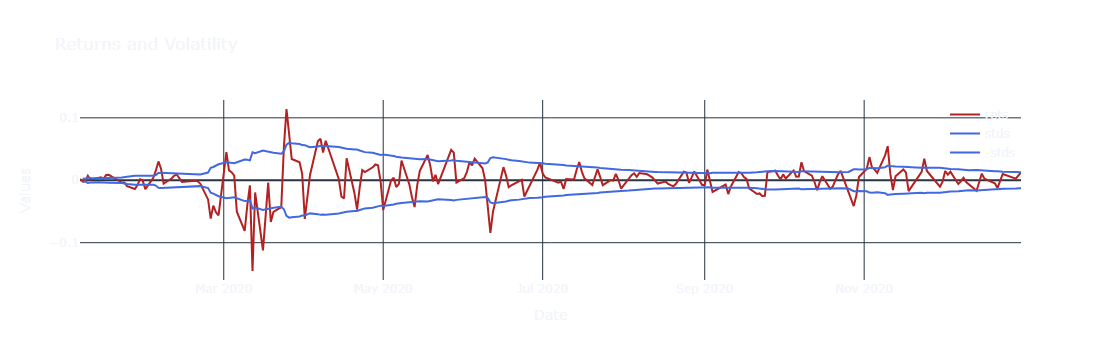

In [11]:
# Save volatility data to Excel using openpyxl to allow appending
with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a') as writer:
    vol.to_excel(writer, sheet_name='Volatility_Data')

# Snippet 3-1: Plotting returns and volatility
fig = go.Figure()
fig.add_trace(go.Scatter(x=vol.index, y=vol['rets'].values, mode="lines", marker=dict(color='firebrick'), name="rets"))
fig.add_trace(go.Scatter(x=vol.index, y=vol['std'].values, mode="lines", marker=dict(color='royalblue'), name="stds"))
fig.add_trace(go.Scatter(x=vol.index, y=-vol['std'].values, mode="lines", marker=dict(color='royalblue'), name="-stds"))

# Apply custom layout
update_figure_layout(fig, "Returns and Volatility", "Date", "Values")
fig.show()

## Event Detection and Triple Barrier Method

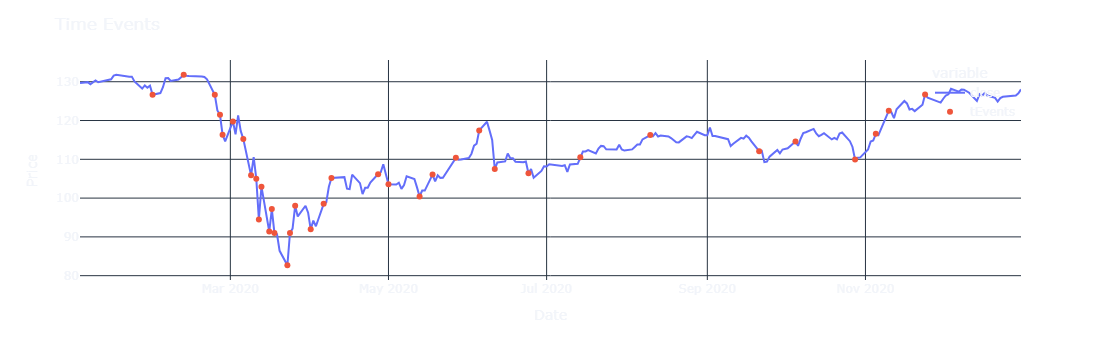

In [12]:
# Time events and triple barrier
timeevents = symmetric_cusum_filter(close, 5)

# Plotting the time events
fig = close.plot()
fig.add_trace(go.Scatter(x=timeevents, y=close[timeevents], mode="markers", name="tEvents"))
update_figure_layout(fig, "Time Events", "Date", "Price")
fig.show()

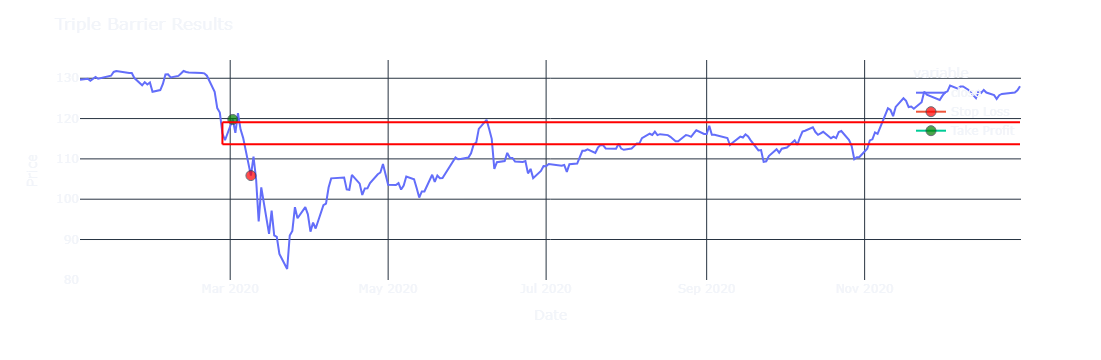

In [13]:
# Save time events data to Excel using openpyxl
with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
    timeevents_df = pd.DataFrame({'timeevents': timeevents})
    timeevents_df.to_excel(writer, sheet_name='TimeEvents_Data', index=False)

# Triple barrier calculations
stds = vol['std']
timestamp = pd.Series(pd.NaT, index=timeevents)
side = pd.Series(1., index=timeevents)
target = stds.loc[timeevents]
ptsl = [1, 1]
events1 = pd.concat({'timestamp': timestamp, 'target': target, 'side': side}, axis=1).dropna(subset=['target'])
events1['End Time'] = timestamp
events1['Base Width'] = target
events1['Side'] = side

# Run the triple barrier function
out = triple_barrier(close, events1, ptsl, molecule=timeevents)
out.head(10)

# Save triple barrier data to Excel using openpyxl
with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
    out.to_excel(writer, sheet_name='TripleBarrier_Data', index=False)

# Plot the triple barrier results
pt, sl = ptsl[0]*target, ptsl[1]*target
upperbound, lowerbound = close[timeevents]*(1 + pt), close[timeevents]*(1 - sl)
i = 4
begining, ending = out.index[i], close.index[-1]
upper, lower = upperbound.iloc[i], lowerbound.iloc[i]
timesl, timept = out['stop_loss'].iloc[i], out['profit_taking'].iloc[i]
pricesl, pricept = close.loc[timesl], close.loc[timept]
fig = close.plot()
fig.add_shape(type="line", x0=begining, y0=upper, x1=begining, y1=lower, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=begining, y0=upper, x1=ending, y1=upper, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=begining, y0=lower, x1=ending, y1=lower, line=dict(color="red", width=2))
fig.add_trace(go.Scatter(x=[timesl], y=[pricesl], marker=dict(size=[10], color=['red']), name="Stop Loss"))
fig.add_trace(go.Scatter(x=[timept], y=[pricept], marker=dict(size=[10], color=['green']), name="Take Profit"))

# Apply custom layout
update_figure_layout(fig, "Triple Barrier Results", "Date", "Price")
fig.show()


## Additional Events and Barriers


In [60]:
t1 = vertical_barrier(close, timeevents, 21)
events2 = meta_events(close, timeevents, ptsl=[1, 1], target=stds, return_min=0.04, num_threads=1, timestamp=t1, side=None)
events2.head()

,End Time,Base Width,target,timestamp
2020-03-12,2020-03-13,0.044984,0.044984,2020-04-02
2020-03-13,2020-03-16,0.043517,0.043517,2020-04-03
2020-03-16,2020-03-17,0.047672,0.047672,2020-04-06
2020-03-17,2020-03-18,0.046638,0.046638,2020-04-07
2020-03-18,2020-03-20,0.045596,0.045596,2020-04-08


In [62]:
# Save events2 data to Excel using openpyxl
with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a') as writer:
    events2.to_excel(writer, sheet_name='Events2_Data_New')

# Plot additional barriers
pt, sl = events2['target'], events2['target']
upperbound, lowerbound = close[events2.index]*(1 + pt), close[events2.index]*(1 - sl)
i = 2
begining, ending = events2.index[i], t1.loc[events2.index].iloc[i]
firsttouch = events2['timestamp'].iloc[i]
pricetouch = close.loc[firsttouch]
u, l = upperbound.iloc[i], lowerbound.iloc[i]
fig = close.plot()
fig.add_shape(type="line", x0=begining, y0=u, x1=begining, y1=l, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=begining, y0=u, x1=ending, y1=u, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=begining, y0=l, x1=ending, y1=l, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=ending, y0=u, x1=ending, y1=l, line=dict(color="red", width=2))
fig.add_trace(go.Scatter(x=[firsttouch], y=[pricetouch], marker=dict(size=[10], color=['red']), name="First Touch"))

# Apply custom layout
update_figure_layout(fig, "Additional Barrier Analysis", "Date", "Price")
fig.show()


ValueError: Sheet 'Events2_Data_New' already exists and if_sheet_exists is set to 'error'.

In [63]:
stds = vol['std']
timestamp = pd.Series(pd.NaT, index = timeevents)
side = pd.Series(1., index = timeevents)
target = stds.loc[timeevents] 
ptsl = [1, 1]
events1 = pd.concat({'timestamp': timestamp, 'target': target, 'side': side}, axis = 1).dropna(subset = ['target'])
events1.head(10)

,timestamp,target,side
2020-01-31,NaT,0.007381,1.0
2020-02-12,NaT,0.010774,1.0
2020-02-24,NaT,0.012431,1.0
2020-02-26,NaT,0.021313,1.0
2020-02-27,NaT,0.023490,1.0
2020-03-02,NaT,0.028828,1.0
2020-03-06,NaT,0.028765,1.0
2020-03-09,NaT,0.033322,1.0
2020-03-11,NaT,0.031893,1.0
2020-03-12,NaT,0.044984,1.0


In [64]:
events1['End Time'] = timestamp
events1['Base Width'] = target
events1['Side'] = side

out = triple_barrier(close, events1, ptsl, molecule = timeevents)
out.head(10)

,End Time,stop_loss,profit_taking
2020-01-31,NaT,2020-02-25,2020-02-04
2020-02-12,NaT,2020-02-24,NaT
2020-02-24,NaT,2020-02-25,NaT
2020-02-26,NaT,2020-02-27,2020-11-16
2020-02-27,NaT,2020-03-09,2020-03-02
2020-03-02,NaT,2020-03-06,2020-11-16
2020-03-06,NaT,2020-03-09,2020-06-08
2020-03-09,NaT,2020-03-12,2020-03-10
2020-03-11,NaT,2020-03-12,2020-04-29
2020-03-12,NaT,2020-03-20,2020-03-13


# Snippet 3.5

In [72]:
out3 = get_labels(events2, close)
out3.head()

,ret,bin
2020-03-12,-0.003280,-1.0
2020-03-13,-0.099218,-1.0
2020-03-16,0.078135,1.0
2020-03-17,0.017907,1.0
2020-03-18,0.130506,1.0


# Snippet 3.6

In [77]:
events3 = meta_events(close, timeevents, ptsl = [1,1], target = stds, return_min = 0.04, num_threads = 1, timestamp = timestamp)
events3.head()

,End Time,Base Width,target,timestamp
2020-03-12,2020-03-13,0.044984,0.044984,2020-04-02
2020-03-13,2020-03-16,0.043517,0.043517,2020-04-03
2020-03-16,2020-03-17,0.047672,0.047672,2020-04-06
2020-03-17,2020-03-18,0.046638,0.046638,2020-04-07
2020-03-18,2020-03-20,0.045596,0.045596,2020-04-08


# Snippet 3.7

In [78]:
out4 = meta_labeling(events3, close)
out4.head()

,End Time,Return,Label
2020-03-12,2020-03-13,0.089471,1.0
2020-03-13,2020-03-16,-0.112428,-1.0
2020-03-16,2020-03-17,0.063362,1.0
2020-03-17,2020-03-18,-0.063188,-1.0
2020-03-18,2020-03-20,-0.050752,-1.0


# Snippet 3.8

In [84]:
def create_bin_column(events: pd.DataFrame) -> pd.DataFrame:
    # Assuming 'ret' (return) is a column in your DataFrame, create a binary column
    events['bin'] = np.sign(events['Return'])
    return events

# Example: Creating 'bin' column for out4 before calling drop_label
out4 = create_bin_column(out4)

# Now you can safely call drop_label
events4 = drop_label(out4, percent_min=0.05)
events4.head(10)

,End Time,Return,Label,bin
2020-03-12,2020-03-13,0.089471,1.0,1.0
2020-03-13,2020-03-16,-0.112428,-1.0,-1.0
2020-03-16,2020-03-17,0.063362,1.0,1.0
2020-03-17,2020-03-18,-0.063188,-1.0,-1.0
2020-03-18,2020-03-20,-0.050752,-1.0,-1.0
2020-03-23,2020-03-24,0.100496,1.0,1.0
2020-03-24,2020-03-26,0.077033,1.0,1.0
2020-03-26,2020-04-01,-0.061728,-1.0,-1.0
2020-04-01,2020-04-06,0.071335,1.0,1.0
2020-04-06,2020-04-09,0.067499,1.0,1.0


In [85]:
events4 = drop_label(out4, percent_min = 0.05)
events4.head(10)

,End Time,Return,Label,bin
2020-03-12,2020-03-13,0.089471,1.0,1.0
2020-03-13,2020-03-16,-0.112428,-1.0,-1.0
2020-03-16,2020-03-17,0.063362,1.0,1.0
2020-03-17,2020-03-18,-0.063188,-1.0,-1.0
2020-03-18,2020-03-20,-0.050752,-1.0,-1.0
2020-03-23,2020-03-24,0.100496,1.0,1.0
2020-03-24,2020-03-26,0.077033,1.0,1.0
2020-03-26,2020-04-01,-0.061728,-1.0,-1.0
2020-04-01,2020-04-06,0.071335,1.0,1.0
2020-04-06,2020-04-09,0.067499,1.0,1.0
